In [20]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import warnings
import gcsfs
from xhistogram.xarray import histogram
import intake
import util
import gsw
import dask

In [21]:
if util.is_ncar_host():
    col = intake.open_esm_datastore("../catalogs/glade-cmip6.json")
else:
    col = intake.open_esm_datastore("../catalogs/pangeo-cmip6.json")
col

pangeo-cmip6-ESM Collection with 28691 entries:
	> 10 activity_id(s)

	> 23 institution_id(s)

	> 48 source_id(s)

	> 29 experiment_id(s)

	> 86 member_id(s)

	> 23 table_id(s)

	> 190 variable_id(s)

	> 7 grid_label(s)

	> 28691 zstore(s)

	> 59 dcpp_init_year(s)

In [22]:
cat = col.search(experiment_id=['historical'], table_id='Omon', institution_id='NCAR', member_id='r1i1p1f1', variable_id=['thetao','so','siconc'], grid_label='gn')
cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year
14596,CMIP,NCAR,CESM2,historical,r1i1p1f1,Omon,so,gn,gs://cmip6/CMIP/NCAR/CESM2/historical/r1i1p1f1...,NaN
14602,CMIP,NCAR,CESM2,historical,r1i1p1f1,Omon,thetao,gn,gs://cmip6/CMIP/NCAR/CESM2/historical/r1i1p1f1...,NaN


In [23]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': True}, 
                                cdf_kwargs={'chunks': {}, 'decode_times': True})
dset_dict.keys()

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)


dict_keys(['CMIP.NCAR.CESM2.historical.Omon.gn'])

In [16]:
def calc_mld(ds):
    # select time range and get August values
    ds = ds.sel(time=slice('1986', '2005')).groupby('time.month').mean().sel(month=8)
    
    # Make depth/lev coordinate uniform in name
    if 'depth' in ds:
        ds.depth = xr.Dataset.rename({'depth':'lev'})
    
    # and units
    if ds.lev.units == 'centimeters':
        ds.lev.values = ds.lev.values/100
    
    # calculate potential density using gibbs sea water package
    cthetao = xr.apply_ufunc(gsw.CT_from_pt, ds.so, ds.thetao, dask='parallelized',
                                             output_dtypes=[float,]).rename('cthetao').to_dataset() 
    #ds = xr.merge([cthetao, ds])
    
    # using sigma0 here to calculate mixed layer depth
    sigma0=xr.apply_ufunc(gsw.density.sigma0,ds.so, cthetao, dask='parallelized', 
                        output_dtypes=[float, ]).rename('sigma0').to_dataset()
    #ds = xr.merge([sigma0, ds])
  
    # Interpolate potential density
    dsi = sigma0.interp(lev=np.linspace(0,20,21))
    surf_dens = dsi.sel(lev = 10)
    
    sigma0.isel(lev=0).plot()
    
    # calculate sigma2
    sigma2=xr.apply_ufunc(gsw.density.sigma2,ds.so, cthetao, dask='parallelized', 
                        output_dtypes=[float, ]).rename('sigma2').to_dataset()
    #ds = xr.merge([sigma2, ds])
    
    # Calculate mixed layer depth based on density difference from 10m
    dens_diff = sigma0 - surf_dens
    dens_diff = dens_diff.where(dens_diff > 0.03)
    mld = dens_diff.lev.where(dens_diff==dens_diff.min(['lev'])).max(['lev'])
    
    #dens_diff.isel(lev=0).plot()
    # add mld to dataset
    ds['mld'] = mld
    
    # find depth of bottom
    test = sigma0 + ds.lev
    print(test)
    bottom_depth = ds.lev.where(test == test.max(dim='lev')).max(dim='lev')
    bottom_depth.plot()
    #add to dataset
    #ds['bottom_depth'] = bottom_depth
    relative_depth = mld/bottom_depth
        
    # find bottom potential density referenced to 2000m and temperature
    bottom_sigma2 = ds.sigma2.where(test == test.max(['lev'])).max(dim='lev')
    #print(bottom_sigma2)
    #ds['bottom_sigma2'] = bottom_sigma2
    
    bottom_temp = ds.thetao.where(test == test.max(['lev'])).max(dim='lev')
    #ds['bottom_temp'] = bottom_temp
    
    print(ds)

    return ds, mld, relative_depth, bottom_sigma2, bottom_temp


for i in dset_dict:
     newds = calc_mld(dset_dict[i])   

ValueError: indexes along dimension 'lev' are not equal

In [15]:
ds = dset_dict['CMIP.NCAR.CESM2.historical.Omon.gn']
cthetao = xr.apply_ufunc(gsw.CT_from_pt, ds.so, ds.thetao, dask='parallelized',
                                             output_dtypes=[float,]).rename('cthetao').to_dataset() 
print(cthetao.cthetao)

<xarray.DataArray 'cthetao' (member_id: 1, time: 1980, lev: 60, nlat: 384, nlon: 320)>
dask.array<CT_from_pt, shape=(1, 1980, 60, 384, 320), dtype=float64, chunksize=(1, 8, 60, 384, 320), chunktype=numpy.ndarray>
Coordinates:
  * nlat       (nlat) int32 1 2 3 4 5 6 7 8 ... 377 378 379 380 381 382 383 384
  * time       (time) object 1850-01-15 13:00:00 ... 2014-12-15 12:00:00
  * lev        (lev) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * nlon       (nlon) int32 1 2 3 4 5 6 7 8 ... 313 314 315 316 317 318 319 320
  * member_id  (member_id) <U8 'r1i1p1f1'


/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray (member_id: 1, lev: 120, nlat: 384, nlon: 320)>
dask.array<add, shape=(1, 120, 384, 320), dtype=float64, chunksize=(1, 120, 384, 320), chunktype=numpy.ndarray>
Coordinates:
  * lev        (lev) float64 5.0 15.0 25.0 ... 4.875e+05 5.125e+05 5.375e+05
  * nlat       (nlat) int32 1 2 3 4 5 6 7 8 ... 377 378 379 380 381 382 383 384
  * member_id  (member_id) <U8 'r1i1p1f1'
  * nlon       (nlon) int32 1 2 3 4 5 6 7 8 ... 313 314 315 316 317 318 319 320
    month      int64 8


/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.7/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


<xarray.Dataset>
Dimensions:         (d2: 2, lev: 120, member_id: 1, nlat: 384, nlon: 320, vertices: 4)
Coordinates:
  * lev             (lev) float64 5.0 15.0 25.0 ... 5.125e+05 5.375e+05
  * nlat            (nlat) int32 1 2 3 4 5 6 7 8 ... 378 379 380 381 382 383 384
  * member_id       (member_id) <U8 'r1i1p1f1'
  * nlon            (nlon) int32 1 2 3 4 5 6 7 8 ... 314 315 316 317 318 319 320
    month           int64 8
Dimensions without coordinates: d2, vertices
Data variables:
    sigma2          (member_id, lev, nlat, nlon) float64 dask.array<chunksize=(1, 120, 384, 320), meta=np.ndarray>
    sigma0          (member_id, lev, nlat, nlon) float64 dask.array<chunksize=(1, 120, 384, 320), meta=np.ndarray>
    cthetao         (member_id, lev, nlat, nlon) float64 dask.array<chunksize=(1, 120, 384, 320), meta=np.ndarray>
    lon_bnds        (nlat, nlon, vertices) float32 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
    lat_bnds        (nlat, nlon, vertices) float32 dask.array<ch

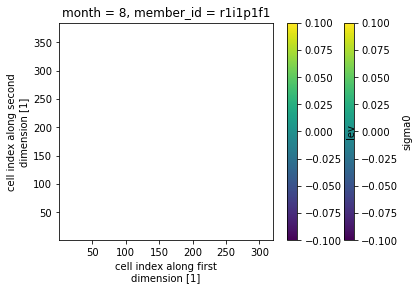

In [27]:
def calc_mld(ds):
    # select time range and get August values
    ds = ds.sel(time=slice('1986', '2005')).groupby('time.month').mean().sel(month=8)
    
    # Make depth/lev coordinate uniform in name
    if 'depth' in ds:
        ds.depth = xr.Dataset.rename({'depth':'lev'})
    
    # and units
    if ds.lev.units == 'centimeters':
        ds.lev.values = ds.lev.values/100
    
    # calculate potential density using gibbs sea water package
    cthetao = xr.apply_ufunc(gsw.CT_from_pt, ds.so, ds.thetao, dask='parallelized',
                                             output_dtypes=[float,]).rename('cthetao').to_dataset() 
    ds = xr.merge([cthetao, ds])
    
    # using sigma0 here to calculate mixed layer depth
    sigma0=xr.apply_ufunc(gsw.density.sigma0,ds.so, ds.cthetao, dask='parallelized', 
                        output_dtypes=[float, ]).rename('sigma0').to_dataset()
    ds = xr.merge([sigma0, ds])
  
    # Interpolate potential density
    dsi = ds.sigma0.interp(lev=np.linspace(0,20,21))
    surf_dens = dsi.sel(lev = 10)
    
    ds.sigma0.isel(lev=0).plot()
    
    # calculate sigma2
    sigma2=xr.apply_ufunc(gsw.density.sigma2,ds.so, ds.cthetao, dask='parallelized', 
                        output_dtypes=[float, ]).rename('sigma2').to_dataset()
    ds = xr.merge([sigma2, ds])
    
    # Calculate mixed layer depth based on density difference from 10m
    dens_diff = ds.sigma0 - surf_dens
    dens_diff = dens_diff.where(dens_diff > 0.03)
    mld = dens_diff.lev.where(dens_diff==dens_diff.min(['lev'])).max(['lev'])
    
    #dens_diff.isel(lev=0).plot()
    # add mld to dataset
    ds['mld'] = mld
    
    # find depth of bottom
    test = ds.sigma0 + ds.lev
    print(test)
    bottom_depth = ds.lev.where(test == test.max(dim='lev')).max(dim='lev')
    bottom_depth.plot()
    #add to dataset
    ds['bottom_depth'] = bottom_depth
    ds['relative_depth'] = mld/bottom_depth
        
    # find bottom potential density referenced to 2000m and temperature
    bottom_sigma2 = ds.sigma2.where(test == test.max(['lev'])).max(dim='lev')
    #print(bottom_sigma2)
    ds['bottom_sigma2'] = bottom_sigma2
    
    bottom_temp = ds.thetao.where(test == test.max(['lev'])).max(dim='lev')
    ds['bottom_temp'] = bottom_temp
    
    print(ds)

    return ds


for i in dset_dict:
     newds = calc_mld(dset_dict[i])  

In [ ]:
bottom_sigma